# Generating new animal faces with conditional GAN models

This notebook tests using conditional GANs for generating animal images. The quality and accuracy of generated images is usually better when we have classes and we train GANS on condition that they come from particular class. Below cGAN is tested and variation of WGAN-GP (Wasserstein GAN with Gradient Penalty) with implemented conditionality.

Idea later is to interpolate between two points from latent space of trained model and predict images for this interpolation. As a desired result, a new hybrid animal face could be obtained as the interpolated result between two classes. This way we control which animals we "mix".

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
from google.colab import drive

drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


# Data loading

In [3]:
MAIN_DIR = '/content/gdrive/MyDrive/ganimals/'
OUTPUT_CGAN_DIR = '/content/gdrive/MyDrive/ganimals/cond_gan_afd/'
OUTPUT_CWGAN_DIR = '/content/gdrive/MyDrive/ganimals/cond_wgan_afd/'

In [4]:
def load_data(path_to_npz):
  '''
  Load image data saved in .npz format and return as np array

  Args:
    path_to_npz - str, path with file name to .npz file with data
  '''
  data = np.load(path_to_npz)
  animals = data['arr_0']
  print('Loaded: ', animals.shape)

  return animals

def preprocess_images(animals, targets):
  '''
  Processing images for normalization and shuffling
  Args:
    animals - np.array, image data
    targets - np.array, classes of images in animals array
  '''
  animals = (animals.astype('float32') - 127.5) / 127.5  # normalize the images to [-1, 1] - this is needed for gan generator
  assert len(animals) == len(targets), 'There should be equal number of samples in images and classes'
  indices = np.arange(len(animals))
  shuffled_indices = np.random.permutation(indices) 

  return animals[shuffled_indices], targets[shuffled_indices]

In [5]:
afd_animals = load_data(MAIN_DIR + 'afd_animals.npz')
afd_targets = load_data(MAIN_DIR + 'afd_targets.npz')
afd_animals, afd_targets = preprocess_images(afd_animals, afd_targets)

Loaded:  (10576, 80, 80, 3)
Loaded:  (10576,)


# Conditional GAN - cGAN
Below there is a baseline for generating images based on class. Implementation details in cgan.py script.

In [17]:
from cgan import ConditionalGAN, GANMonitor

import tensorflow as tf
from keras.utils import to_categorical 

In [9]:
batch_size = 256
num_channels = 3
num_classes = 19
image_size = 80
latent_dim = 100

In [7]:
# one-hot encode the labels
afd_targets_onehot = to_categorical(afd_targets)
afd_targets_onehot.shape

(10576, 19)

In [8]:
# create tf.data.Dataset
dataset = tf.data.Dataset.from_tensor_slices((afd_animals, afd_targets_onehot))
dataset = dataset.shuffle(buffer_size=1024).batch(batch_size)

In [13]:
cbk = GANMonitor(num_classes=num_classes, epoch_summarize=10, latent_dim=latent_dim) # callback for saving generator model and images after every epoch_summarize epoch

cgan = ConditionalGAN(num_classes=num_classes, latent_dim=latent_dim) # cGAN model
cgan.compile()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 40, 40, 128)       70528     
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 40, 40, 128)       0         
                                                                 
 conv2d_7 (Conv2D)           (None, 20, 20, 128)       409728    
                                                                 
 leaky_re_lu_11 (LeakyReLU)  (None, 20, 20, 128)       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 10, 10, 128)       409728    
                                                                 
 leaky_re_lu_12 (LeakyReLU)  (None, 10, 10, 128)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 5, 5, 128)       

In [14]:
# to save intermediate models and images to desired directory
os.chdir(OUTPUT_CGAN_DIR)

In [12]:
cgan.fit(dataset, epochs=200, callbacks=[cbk])

Epoch 1/200
42/42 [==============================] - 70s 1s/step - d_loss: 0.2538 - g_loss: 3.2743
Epoch 2/200
42/42 [==============================] - 41s 974ms/step - d_loss: 0.1417 - g_loss: 4.8320
Epoch 3/200
42/42 [==============================] - 41s 980ms/step - d_loss: 0.0573 - g_loss: 4.6782
Epoch 4/200
42/42 [==============================] - 42s 990ms/step - d_loss: 0.0356 - g_loss: 6.0432
Epoch 5/200
42/42 [==============================] - 41s 971ms/step - d_loss: 0.0278 - g_loss: 6.4849
Epoch 6/200
42/42 [==============================] - 41s 976ms/step - d_loss: 0.0295 - g_loss: 6.7835
Epoch 7/200
42/42 [==============================] - 41s 976ms/step - d_loss: 0.0492 - g_loss: 7.0593
Epoch 8/200
42/42 [==============================] - 41s 973ms/step - d_loss: 0.4556 - g_loss: 12.7933
Epoch 9/200
42/42 [==============================] - 40s 963ms/step - d_loss: 0.2091 - g_loss: 17.5609
Epoch 10/200
42/42 [==============================] - ETA: 0s - d_loss: 0.6918 - g_

42/42 [==============================] - 44s 1s/step - d_loss: 0.6918 - g_loss: 12.2756
Epoch 11/200
42/42 [==============================] - 41s 986ms/step - d_loss: 0.7873 - g_loss: 3.9684
Epoch 12/200
42/42 [==============================] - 42s 996ms/step - d_loss: 0.4186 - g_loss: 4.4055
Epoch 13/200
42/42 [==============================] - 41s 984ms/step - d_loss: 0.5518 - g_loss: 2.1192
Epoch 14/200
42/42 [==============================] - 41s 986ms/step - d_loss: 0.4836 - g_loss: 1.6041
Epoch 15/200
42/42 [==============================] - 41s 984ms/step - d_loss: 0.4579 - g_loss: 1.8223
Epoch 16/200
42/42 [==============================] - 42s 998ms/step - d_loss: 0.3929 - g_loss: 2.3750
Epoch 17/200
42/42 [==============================] - 42s 995ms/step - d_loss: 0.4093 - g_loss: 2.7580
Epoch 18/200
42/42 [==============================] - 42s 999ms/step - d_loss: 0.3786 - g_loss: 2.3538
Epoch 19/200
42/42 [==============================] - 41s 985ms/step - d_loss: 0.3988 - 

42/42 [==============================] - 45s 1s/step - d_loss: 0.3790 - g_loss: 2.2706
Epoch 21/200
42/42 [==============================] - 41s 983ms/step - d_loss: 0.3634 - g_loss: 2.3732
Epoch 22/200
42/42 [==============================] - 42s 1s/step - d_loss: 0.3888 - g_loss: 2.2405
Epoch 23/200
42/42 [==============================] - 42s 1s/step - d_loss: 0.4050 - g_loss: 2.2324
Epoch 24/200
42/42 [==============================] - 41s 981ms/step - d_loss: 0.4485 - g_loss: 2.2139
Epoch 25/200
42/42 [==============================] - 41s 987ms/step - d_loss: 0.4239 - g_loss: 2.1308
Epoch 26/200
42/42 [==============================] - 42s 997ms/step - d_loss: 0.3701 - g_loss: 2.3851
Epoch 27/200
42/42 [==============================] - 42s 998ms/step - d_loss: 0.4274 - g_loss: 2.3130
Epoch 28/200
42/42 [==============================] - 42s 998ms/step - d_loss: 0.3992 - g_loss: 2.5016
Epoch 29/200
42/42 [==============================] - 42s 999ms/step - d_loss: 0.3872 - g_loss:

42/42 [==============================] - 44s 1s/step - d_loss: 0.4004 - g_loss: 2.2912
Epoch 31/200
42/42 [==============================] - 42s 998ms/step - d_loss: 0.4045 - g_loss: 2.3299
Epoch 32/200
42/42 [==============================] - 42s 997ms/step - d_loss: 0.3715 - g_loss: 2.4679
Epoch 33/200
42/42 [==============================] - 42s 998ms/step - d_loss: 0.3585 - g_loss: 2.6769
Epoch 34/200
42/42 [==============================] - 42s 996ms/step - d_loss: 0.3653 - g_loss: 2.4880
Epoch 35/200
42/42 [==============================] - 41s 984ms/step - d_loss: 0.4032 - g_loss: 2.4141
Epoch 36/200
42/42 [==============================] - 42s 998ms/step - d_loss: 0.3927 - g_loss: 2.2885
Epoch 37/200
42/42 [==============================] - 41s 983ms/step - d_loss: 0.3753 - g_loss: 2.3168
Epoch 38/200
42/42 [==============================] - 42s 997ms/step - d_loss: 0.3854 - g_loss: 2.3009
Epoch 39/200
42/42 [==============================] - 41s 984ms/step - d_loss: 0.3868 - g

42/42 [==============================] - 45s 1s/step - d_loss: 0.3676 - g_loss: 2.3722
Epoch 41/200
42/42 [==============================] - 42s 997ms/step - d_loss: 0.3759 - g_loss: 2.3968
Epoch 42/200
42/42 [==============================] - 41s 986ms/step - d_loss: 0.3652 - g_loss: 2.5010
Epoch 43/200
42/42 [==============================] - 41s 985ms/step - d_loss: 0.3726 - g_loss: 2.3853
Epoch 44/200
42/42 [==============================] - 42s 997ms/step - d_loss: 0.3547 - g_loss: 2.5184
Epoch 45/200
42/42 [==============================] - 42s 998ms/step - d_loss: 0.3496 - g_loss: 2.5100
Epoch 46/200
42/42 [==============================] - 41s 985ms/step - d_loss: 0.3473 - g_loss: 2.5463
Epoch 47/200
42/42 [==============================] - 41s 985ms/step - d_loss: 0.3415 - g_loss: 2.5715
Epoch 48/200
42/42 [==============================] - 41s 985ms/step - d_loss: 0.3392 - g_loss: 2.5736
Epoch 49/200
42/42 [==============================] - 41s 984ms/step - d_loss: 0.3298 - g

42/42 [==============================] - 44s 1s/step - d_loss: 0.3302 - g_loss: 2.6379
Epoch 51/200
42/42 [==============================] - 41s 984ms/step - d_loss: 0.3320 - g_loss: 2.6570
Epoch 52/200
42/42 [==============================] - 42s 995ms/step - d_loss: 0.3164 - g_loss: 2.7488
Epoch 53/200
42/42 [==============================] - 42s 1000ms/step - d_loss: 0.3137 - g_loss: 2.7495
Epoch 54/200
42/42 [==============================] - 41s 985ms/step - d_loss: 0.2970 - g_loss: 2.7935
Epoch 55/200
42/42 [==============================] - 42s 997ms/step - d_loss: 0.2925 - g_loss: 2.8666
Epoch 56/200
42/42 [==============================] - 42s 997ms/step - d_loss: 0.3040 - g_loss: 2.8835
Epoch 57/200
42/42 [==============================] - 42s 999ms/step - d_loss: 0.2987 - g_loss: 2.8125
Epoch 58/200
42/42 [==============================] - 42s 997ms/step - d_loss: 0.2966 - g_loss: 2.8204
Epoch 59/200
42/42 [==============================] - 42s 999ms/step - d_loss: 0.2959 - 

42/42 [==============================] - 44s 1s/step - d_loss: 0.2908 - g_loss: 2.8549
Epoch 61/200
42/42 [==============================] - 42s 989ms/step - d_loss: 0.2861 - g_loss: 2.8989
Epoch 62/200
42/42 [==============================] - 41s 983ms/step - d_loss: 0.2992 - g_loss: 2.8801
Epoch 63/200
42/42 [==============================] - 41s 988ms/step - d_loss: 0.2877 - g_loss: 2.8977
Epoch 64/200
42/42 [==============================] - 41s 985ms/step - d_loss: 0.2846 - g_loss: 2.9034
Epoch 65/200
42/42 [==============================] - 41s 984ms/step - d_loss: 0.2850 - g_loss: 2.9346
Epoch 66/200
42/42 [==============================] - 42s 1s/step - d_loss: 0.2690 - g_loss: 2.9413
Epoch 67/200
42/42 [==============================] - 42s 993ms/step - d_loss: 0.2795 - g_loss: 2.9784
Epoch 68/200
42/42 [==============================] - 42s 1s/step - d_loss: 0.2688 - g_loss: 3.0846
Epoch 69/200
42/42 [==============================] - 42s 997ms/step - d_loss: 0.2749 - g_loss:

42/42 [==============================] - 44s 1s/step - d_loss: 0.2712 - g_loss: 3.1483
Epoch 71/200
42/42 [==============================] - 42s 999ms/step - d_loss: 0.2574 - g_loss: 3.1338
Epoch 72/200
42/42 [==============================] - 42s 1000ms/step - d_loss: 0.2441 - g_loss: 3.2414
Epoch 73/200
42/42 [==============================] - 41s 985ms/step - d_loss: 0.2561 - g_loss: 3.3425
Epoch 74/200
42/42 [==============================] - 42s 997ms/step - d_loss: 0.2496 - g_loss: 3.3059
Epoch 75/200
42/42 [==============================] - 42s 999ms/step - d_loss: 0.2503 - g_loss: 3.2583
Epoch 76/200
42/42 [==============================] - 42s 997ms/step - d_loss: 0.2415 - g_loss: 3.4569
Epoch 77/200
42/42 [==============================] - 42s 998ms/step - d_loss: 0.2350 - g_loss: 3.4494
Epoch 78/200
42/42 [==============================] - 42s 1s/step - d_loss: 0.2324 - g_loss: 3.4728
Epoch 79/200
42/42 [==============================] - 42s 1s/step - d_loss: 0.2295 - g_loss

42/42 [==============================] - 44s 1s/step - d_loss: 0.2244 - g_loss: 3.6530
Epoch 81/200
42/42 [==============================] - 42s 1s/step - d_loss: 0.2280 - g_loss: 3.6005
Epoch 82/200
42/42 [==============================] - 41s 980ms/step - d_loss: 0.2186 - g_loss: 3.7357
Epoch 83/200
42/42 [==============================] - 41s 987ms/step - d_loss: 0.2222 - g_loss: 3.7273
Epoch 84/200
42/42 [==============================] - 42s 1s/step - d_loss: 0.2185 - g_loss: 3.7675
Epoch 85/200
42/42 [==============================] - 41s 983ms/step - d_loss: 0.2086 - g_loss: 3.7732
Epoch 86/200
42/42 [==============================] - 42s 999ms/step - d_loss: 0.2044 - g_loss: 3.7689
Epoch 87/200
42/42 [==============================] - 42s 1000ms/step - d_loss: 0.2098 - g_loss: 3.8708
Epoch 88/200
42/42 [==============================] - 41s 984ms/step - d_loss: 0.2152 - g_loss: 3.8526
Epoch 89/200
42/42 [==============================] - 42s 998ms/step - d_loss: 0.2044 - g_loss

42/42 [==============================] - 45s 1s/step - d_loss: 0.1950 - g_loss: 3.9709
Epoch 91/200
42/42 [==============================] - 42s 999ms/step - d_loss: 0.1958 - g_loss: 4.0495
Epoch 92/200
42/42 [==============================] - 42s 999ms/step - d_loss: 0.2070 - g_loss: 4.0306
Epoch 93/200
42/42 [==============================] - 42s 1s/step - d_loss: 0.1887 - g_loss: 4.0718
Epoch 94/200
42/42 [==============================] - 41s 984ms/step - d_loss: 0.1873 - g_loss: 4.0443
Epoch 95/200
42/42 [==============================] - 41s 984ms/step - d_loss: 0.1899 - g_loss: 4.1380
Epoch 96/200
42/42 [==============================] - 42s 1s/step - d_loss: 0.1832 - g_loss: 4.2626
Epoch 97/200
42/42 [==============================] - 42s 998ms/step - d_loss: 0.1827 - g_loss: 4.2989
Epoch 98/200
42/42 [==============================] - 42s 999ms/step - d_loss: 0.1705 - g_loss: 4.3142
Epoch 99/200
42/42 [==============================] - 42s 1s/step - d_loss: 0.1789 - g_loss: 4.

42/42 [==============================] - 45s 1s/step - d_loss: 0.1801 - g_loss: 4.3026
Epoch 101/200
42/42 [==============================] - 42s 990ms/step - d_loss: 0.1649 - g_loss: 4.2751
Epoch 102/200
42/42 [==============================] - 42s 1s/step - d_loss: 0.1721 - g_loss: 4.4117
Epoch 103/200
42/42 [==============================] - 41s 981ms/step - d_loss: 0.1806 - g_loss: 4.5072
Epoch 104/200
42/42 [==============================] - 42s 1s/step - d_loss: 0.1740 - g_loss: 4.4917
Epoch 105/200
42/42 [==============================] - 42s 1s/step - d_loss: 0.1645 - g_loss: 4.5602
Epoch 106/200
42/42 [==============================] - 41s 983ms/step - d_loss: 0.1695 - g_loss: 4.5469
Epoch 107/200
42/42 [==============================] - 41s 986ms/step - d_loss: 0.1641 - g_loss: 4.5982
Epoch 108/200
42/42 [==============================] - 42s 1s/step - d_loss: 0.1641 - g_loss: 4.6513
Epoch 109/200
42/42 [==============================] - 42s 1s/step - d_loss: 0.1626 - g_loss:

42/42 [==============================] - 43s 1s/step - d_loss: 0.1583 - g_loss: 4.7625
Epoch 111/200
42/42 [==============================] - 42s 1s/step - d_loss: 0.1649 - g_loss: 4.5875
Epoch 112/200
42/42 [==============================] - 41s 980ms/step - d_loss: 0.1536 - g_loss: 4.7214
Epoch 113/200
42/42 [==============================] - 42s 1s/step - d_loss: 0.1578 - g_loss: 4.7521
Epoch 114/200
42/42 [==============================] - 41s 979ms/step - d_loss: 0.1590 - g_loss: 4.7964
Epoch 115/200
42/42 [==============================] - 42s 990ms/step - d_loss: 0.1555 - g_loss: 4.7243
Epoch 116/200
42/42 [==============================] - 41s 983ms/step - d_loss: 0.1478 - g_loss: 4.8050
Epoch 117/200
42/42 [==============================] - 42s 999ms/step - d_loss: 0.1569 - g_loss: 4.7890
Epoch 118/200
42/42 [==============================] - 42s 996ms/step - d_loss: 0.1524 - g_loss: 4.8244
Epoch 119/200
42/42 [==============================] - 42s 998ms/step - d_loss: 0.1497 

42/42 [==============================] - 43s 1s/step - d_loss: 0.1515 - g_loss: 4.8863
Epoch 121/200
42/42 [==============================] - 41s 985ms/step - d_loss: 0.1414 - g_loss: 4.9372
Epoch 122/200
42/42 [==============================] - 42s 999ms/step - d_loss: 0.1378 - g_loss: 4.9057
Epoch 123/200
42/42 [==============================] - 42s 997ms/step - d_loss: 0.1305 - g_loss: 5.1541
Epoch 124/200
42/42 [==============================] - 41s 985ms/step - d_loss: 0.1447 - g_loss: 5.0270
Epoch 125/200
42/42 [==============================] - 41s 986ms/step - d_loss: 0.1357 - g_loss: 5.0685
Epoch 126/200
42/42 [==============================] - 42s 998ms/step - d_loss: 0.1466 - g_loss: 5.0796
Epoch 127/200
42/42 [==============================] - 41s 985ms/step - d_loss: 0.1378 - g_loss: 5.0653
Epoch 128/200
42/42 [==============================] - 41s 987ms/step - d_loss: 0.1395 - g_loss: 5.1628
Epoch 129/200
42/42 [==============================] - 42s 997ms/step - d_loss: 0

42/42 [==============================] - 45s 1s/step - d_loss: 0.1336 - g_loss: 5.2155
Epoch 131/200
42/42 [==============================] - 42s 995ms/step - d_loss: 0.1301 - g_loss: 5.2488
Epoch 132/200
42/42 [==============================] - 42s 999ms/step - d_loss: 0.1334 - g_loss: 5.2628
Epoch 133/200
42/42 [==============================] - 41s 984ms/step - d_loss: 0.1239 - g_loss: 5.3943
Epoch 134/200
42/42 [==============================] - 41s 987ms/step - d_loss: 0.1308 - g_loss: 5.3695
Epoch 135/200
42/42 [==============================] - 41s 985ms/step - d_loss: 0.1189 - g_loss: 5.2903
Epoch 136/200
42/42 [==============================] - 41s 985ms/step - d_loss: 0.1478 - g_loss: 5.4102
Epoch 137/200
42/42 [==============================] - 42s 997ms/step - d_loss: 0.1185 - g_loss: 5.3507
Epoch 138/200
42/42 [==============================] - 42s 998ms/step - d_loss: 0.1331 - g_loss: 5.3164
Epoch 139/200
42/42 [==============================] - 41s 985ms/step - d_loss: 0

42/42 [==============================] - 44s 1s/step - d_loss: 0.1271 - g_loss: 5.5228
Epoch 141/200
42/42 [==============================] - 42s 997ms/step - d_loss: 0.1182 - g_loss: 5.4597
Epoch 142/200
42/42 [==============================] - 41s 985ms/step - d_loss: 0.1171 - g_loss: 5.4615
Epoch 143/200
42/42 [==============================] - 41s 984ms/step - d_loss: 0.1145 - g_loss: 5.5773
Epoch 144/200
42/42 [==============================] - 42s 988ms/step - d_loss: 0.1262 - g_loss: 5.5964
Epoch 145/200
42/42 [==============================] - 42s 995ms/step - d_loss: 0.1208 - g_loss: 5.6738
Epoch 146/200
42/42 [==============================] - 42s 998ms/step - d_loss: 0.1102 - g_loss: 5.6275
Epoch 147/200
42/42 [==============================] - 42s 998ms/step - d_loss: 0.1229 - g_loss: 5.6585
Epoch 148/200
42/42 [==============================] - 42s 999ms/step - d_loss: 0.1215 - g_loss: 5.5427
Epoch 149/200
42/42 [==============================] - 42s 998ms/step - d_loss: 0

42/42 [==============================] - 44s 1s/step - d_loss: 0.1161 - g_loss: 5.7602
Epoch 151/200
42/42 [==============================] - 41s 985ms/step - d_loss: 0.1056 - g_loss: 5.7966
Epoch 152/200
42/42 [==============================] - 42s 988ms/step - d_loss: 0.1258 - g_loss: 5.8830
Epoch 153/200
42/42 [==============================] - 41s 984ms/step - d_loss: 0.1121 - g_loss: 5.7366
Epoch 154/200
42/42 [==============================] - 41s 987ms/step - d_loss: 0.0992 - g_loss: 5.8290
Epoch 155/200
42/42 [==============================] - 42s 988ms/step - d_loss: 0.1119 - g_loss: 5.8052
Epoch 156/200
42/42 [==============================] - 42s 999ms/step - d_loss: 0.1081 - g_loss: 6.0270
Epoch 157/200
42/42 [==============================] - 42s 997ms/step - d_loss: 0.1102 - g_loss: 5.8751
Epoch 158/200
42/42 [==============================] - 42s 1s/step - d_loss: 0.1087 - g_loss: 5.8816
Epoch 159/200
42/42 [==============================] - 41s 980ms/step - d_loss: 0.10

42/42 [==============================] - 44s 1s/step - d_loss: 0.1044 - g_loss: 5.9650
Epoch 161/200
42/42 [==============================] - 42s 996ms/step - d_loss: 0.1208 - g_loss: 6.0481
Epoch 162/200
42/42 [==============================] - 41s 986ms/step - d_loss: 0.0958 - g_loss: 6.0765
Epoch 163/200
42/42 [==============================] - 41s 984ms/step - d_loss: 0.1010 - g_loss: 5.9431
Epoch 164/200
42/42 [==============================] - 41s 985ms/step - d_loss: 0.0941 - g_loss: 6.1290
Epoch 165/200
42/42 [==============================] - 42s 997ms/step - d_loss: 0.0996 - g_loss: 6.2057
Epoch 166/200
42/42 [==============================] - 42s 998ms/step - d_loss: 0.1006 - g_loss: 6.1218
Epoch 167/200
42/42 [==============================] - 41s 984ms/step - d_loss: 0.0959 - g_loss: 6.1610
Epoch 168/200
42/42 [==============================] - 42s 996ms/step - d_loss: 0.1005 - g_loss: 6.2441
Epoch 169/200
42/42 [==============================] - 41s 984ms/step - d_loss: 0

42/42 [==============================] - 46s 1s/step - d_loss: 0.0960 - g_loss: 6.2837
Epoch 171/200
42/42 [==============================] - 42s 999ms/step - d_loss: 0.1001 - g_loss: 6.3267
Epoch 172/200
42/42 [==============================] - 42s 999ms/step - d_loss: 0.0947 - g_loss: 6.3714
Epoch 173/200
42/42 [==============================] - 42s 1s/step - d_loss: 0.0990 - g_loss: 6.3838
Epoch 174/200
42/42 [==============================] - 42s 1s/step - d_loss: 0.0932 - g_loss: 6.3331
Epoch 175/200
42/42 [==============================] - 42s 999ms/step - d_loss: 0.1007 - g_loss: 6.4089
Epoch 176/200
42/42 [==============================] - 41s 984ms/step - d_loss: 0.0995 - g_loss: 6.3020
Epoch 177/200
42/42 [==============================] - 42s 1s/step - d_loss: 0.0951 - g_loss: 6.3963
Epoch 178/200
42/42 [==============================] - 42s 1s/step - d_loss: 0.0912 - g_loss: 6.3757
Epoch 179/200
42/42 [==============================] - 42s 1s/step - d_loss: 0.0901 - g_loss:

42/42 [==============================] - 43s 1s/step - d_loss: 0.0829 - g_loss: 6.5171
Epoch 181/200
42/42 [==============================] - 42s 1s/step - d_loss: 0.0885 - g_loss: 6.5341
Epoch 182/200
42/42 [==============================] - 41s 983ms/step - d_loss: 0.0916 - g_loss: 6.5012
Epoch 183/200
42/42 [==============================] - 42s 1s/step - d_loss: 0.0925 - g_loss: 6.6510
Epoch 184/200
42/42 [==============================] - 41s 984ms/step - d_loss: 0.0880 - g_loss: 6.6684
Epoch 185/200
42/42 [==============================] - 42s 1s/step - d_loss: 0.0858 - g_loss: 6.7050
Epoch 186/200
42/42 [==============================] - 42s 999ms/step - d_loss: 0.0851 - g_loss: 6.7124
Epoch 187/200
42/42 [==============================] - 41s 984ms/step - d_loss: 0.0854 - g_loss: 6.7066
Epoch 188/200
42/42 [==============================] - 41s 984ms/step - d_loss: 0.0873 - g_loss: 6.8032
Epoch 189/200
42/42 [==============================] - 41s 987ms/step - d_loss: 0.1003 - g

42/42 [==============================] - 43s 1s/step - d_loss: 0.0806 - g_loss: 6.6337
Epoch 191/200
42/42 [==============================] - 41s 986ms/step - d_loss: 0.0935 - g_loss: 6.8997
Epoch 192/200
42/42 [==============================] - 41s 988ms/step - d_loss: 0.0858 - g_loss: 6.8188
Epoch 193/200
42/42 [==============================] - 41s 986ms/step - d_loss: 0.0835 - g_loss: 6.8045
Epoch 194/200
42/42 [==============================] - 41s 986ms/step - d_loss: 0.0794 - g_loss: 6.8075
Epoch 195/200
42/42 [==============================] - 41s 985ms/step - d_loss: 0.0835 - g_loss: 6.8380
Epoch 196/200
42/42 [==============================] - 41s 985ms/step - d_loss: 0.0893 - g_loss: 6.7582
Epoch 197/200
42/42 [==============================] - 41s 984ms/step - d_loss: 0.0817 - g_loss: 6.8908
Epoch 198/200
42/42 [==============================] - 41s 985ms/step - d_loss: 0.0804 - g_loss: 6.8346
Epoch 199/200
42/42 [==============================] - 42s 1s/step - d_loss: 0.07

42/42 [==============================] - 44s 1s/step - d_loss: 0.0847 - g_loss: 6.9247


## Loading saved model

In [13]:
from keras.models import load_model
import matplotlib.image as mpimg
import tensorflow as tf
from keras.utils import to_categorical 

In [6]:
generator_cgan = load_model(OUTPUT_CGAN_DIR + 'generator_model_200.h5') # pick best performing model based on saved plots while training

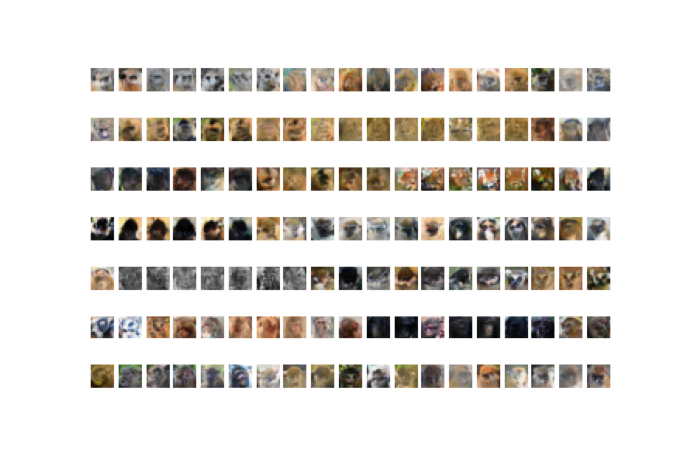

In [88]:
img = mpimg.imread(OUTPUT_CGAN_DIR + 'generated_plot_e200.png')

plt.figure(figsize=(12,12))
plt.imshow(img)
plt.axis('off')
plt.show()

In [8]:
def load_classes(path_to_npz):
  '''
  Load dict of classes of dataset saved as pickle with .npz extension
  Args:
    path_to_npz - str, directory with file name
  '''
  data = np.load(path_to_npz, allow_pickle=True)
  classes = data['arr_0'].item()

  return classes

In [11]:
path_to_classes = MAIN_DIR + 'afd_class_dict.npz'
classes_dict = load_classes(path_to_classes)

In [12]:
# process to list and display
classes_list = [str(values) + ') '+ keys for keys, values in zip(classes_dict.keys(), classes_dict.values())]
classes_list

['0) mongooses',
 '1) Mandrillus sphinx',
 '2) Papio anubis',
 '3) Cebus olivaceus',
 '4) Panthera leo',
 '5) Cebus apella',
 '6) Nomascus leucogenys',
 '7) Ailurus fulgens',
 '8) Trachypithecus francoisi',
 '9) Chlorocebus sabaeus',
 '10) Cercopithecus neglectus',
 '11) Panthera tigris',
 '12) Cercopithecus nictitans',
 '13) Lemur catta',
 '14) Macaca mulatta',
 '15) Pan troglodytes',
 '16) Macaca thibetana',
 '17) Saimiri sciureus',
 '18) Erythrocebus patas']

1/1 [==============================] - 1s 1s/step


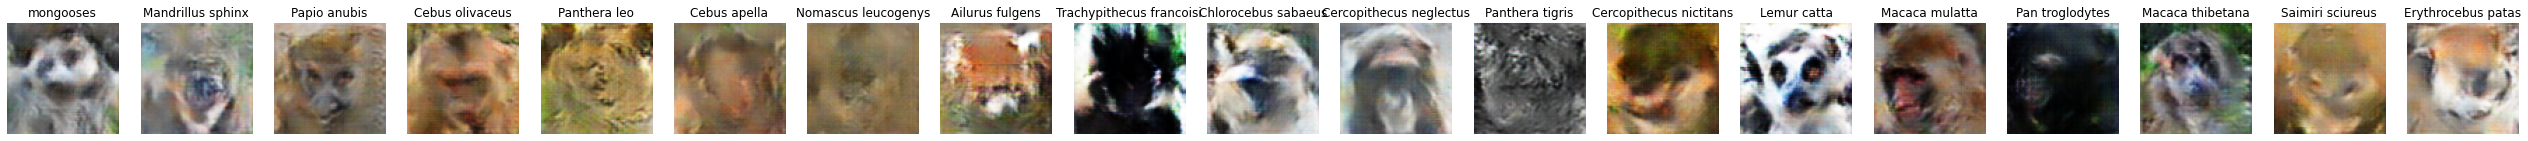

In [117]:
def generate_image(generator, latent_dim=latent_dim, onehot_encoded=True):
  # sample noise for the interpolation.
  interpolation_noise = tf.random.normal(shape=(num_classes, latent_dim))
  classes = tf.cast(list(classes_dict.values()), tf.uint8)

  if onehot_encoded:
    onehot_classes = to_categorical(classes)
    noise_and_labels = tf.concat([interpolation_noise, onehot_classes], 1)
    fake_img = generator.predict(noise_and_labels)
  else:
    fake_img = generator.predict([interpolation_noise, classes])

  return fake_img

def plot_generated(fake_images, n):


  fake_images = (fake_images + 1)/2.0

  plt.figure(figsize=(45,45))
  for i in range(n):

    plt.subplot(1, n, 1 + i)
    plt.axis('off')
    plt.imshow(fake_images[i])
    plt.title(list(classes_dict.keys())[i])
  
  plt.show()

# generate some individual examples
img = generate_image(generator_cgan, onehot_encoded=True)
plot_generated(img, num_classes)

## Exploring latent space and interpolation

The generative model in GAN models learns to map points in the latent space to generated images. The latent space has no meaning other than the meaning applied to it via the generative model. Yet, the latent space has structure that can be explored, such as by interpolating between points and performing vector arithmetic between points in latent space which have meaningful and targeted effects on the generated images.

**Here, the main idea was that while we can generate image from two particular animal classes, when we interpolate between them in latent space and plot them, the intermediate image will be a "hybrid" of two animals.**

In [11]:
def interpolate_class(generator, first_number, second_number, n_steps=10, latent_dim=100, onehot_encoded=True):

    # sample noise for the interpolation.
    interpolation_noise = tf.random.normal(shape=(n_steps, latent_dim))

    # calculate the interpolation vector between the two labels
    if onehot_encoded:
      # convert the start and end labels to one-hot encoded vectors
      first_number = to_categorical([first_number], num_classes)
      second_number = to_categorical([second_number], num_classes)
      
      first_number = tf.cast(first_number, tf.float32)
      second_number = tf.cast(second_number, tf.float32)


    percent_second_label = tf.linspace(0, 1, n_steps)[:, None]
    percent_second_label = tf.cast(percent_second_label, tf.float32)
    interpolation_labels =  ((1 - percent_second_label) * first_number + second_number * percent_second_label)

    # using fact that for cGAN I used one-hot encoding but for cWGAN label encoding with embedding, therefore input is different
    if onehot_encoded:
      noise_and_labels = tf.concat([interpolation_noise, interpolation_labels], 1)
      fake = generator.predict(noise_and_labels)
    else:
      fake = generator.predict([interpolation_noise, interpolation_labels])

    return fake


def plot_interpolated(fake_images):

  fake_images = (fake_images + 1) / 2.0
  fake_images = tf.image.resize(fake_images, (80, 80)).numpy() 

  assert fake_images.shape == (n_steps, image_size, image_size, num_channels)

  plt.figure(figsize=(15,10))

  for i in range(len(fake_images)):
    plt.subplot(1, len(fake_images), 1 + i)
    plt.axis('off')
    plt.imshow(fake_images[i])

  plt.show()


def display_interpolated(generator, yA, yB, num_interpolation, n_steps=10, onehot_encoded=True):
  
  for i in range(0, num_interpolation):
    fake_images = interpolate_class(generator, yA, yB, n_steps, latent_dim, onehot_encoded)
    plot_interpolated(fake_images)

You can change classes between which model interpolates from dropdown menu here.

1/1 [==============================] - 1s 1s/step


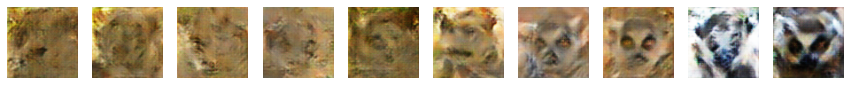

1/1 [==============================] - 1s 505ms/step


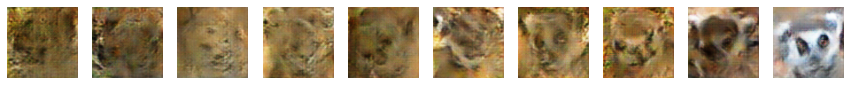

1/1 [==============================] - 1s 502ms/step


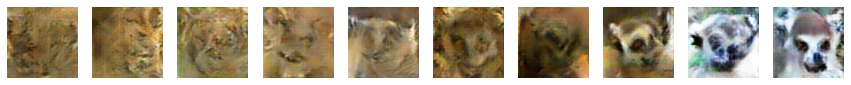

1/1 [==============================] - 0s 492ms/step


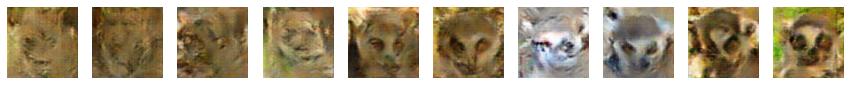

1/1 [==============================] - 0s 495ms/step


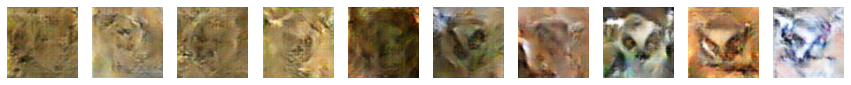

In [35]:
# choose the number of intermediate images that would be generated in
# between the interpolation + 2 (start and last images)
n_steps = 10  # @param {type:"integer"}

# how many examples to generate from this class
num_interpolation = 5 # @param {type:"integer"}

categoryA = "4) Panthera leo" #@param ['0) mongooses', '1) Mandrillus sphinx', '2) Papio anubis', '3) Cebus olivaceus', '4) Panthera leo','5) Cebus apella','6) Nomascus leucogenys','7) Ailurus fulgens','8) Trachypithecus francoisi','9) Chlorocebus sabaeus','10) Cercopithecus neglectus', '11) Panthera tigris', '12) Cercopithecus nictitans','13) Lemur catta','14) Macaca mulatta','15) Pan troglodytes','16) Macaca thibetana','17) Saimiri sciureus','18) Erythrocebus patas']
categoryB = "13) Lemur catta" #@param ['0) mongooses', '1) Mandrillus sphinx', '2) Papio anubis', '3) Cebus olivaceus', '4) Panthera leo','5) Cebus apella','6) Nomascus leucogenys','7) Ailurus fulgens','8) Trachypithecus francoisi','9) Chlorocebus sabaeus','10) Cercopithecus neglectus', '11) Panthera tigris', '12) Cercopithecus nictitans','13) Lemur catta','14) Macaca mulatta','15) Pan troglodytes','16) Macaca thibetana','17) Saimiri sciureus','18) Erythrocebus patas']

yA = int(categoryA.split(')')[0])
yB = int(categoryB.split(')')[0])

display_interpolated(generator_cgan, yA, yB, num_interpolation, n_steps)

# Conditional WGAN-GP

In [30]:
# load conditional WGAN-GP from cwgan_gp script
from cwgan_gp import cWGAN, GANMonitor

In [31]:
cbk = GANMonitor(epoch_summarize=10, latent_dim=latent_dim)

# Get the wgan model
cwgan = cWGAN(num_classes=num_classes, d_steps=5, latent_dim=latent_dim)

# Compile the wgan model
cwgan.compile()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 40, 40, 64)        9664      
                                                                 
 leaky_re_lu_20 (LeakyReLU)  (None, 40, 40, 64)        0         
                                                                 
 dropout_2 (Dropout)         (None, 40, 40, 64)        0         
                                                                 
 conv2d_13 (Conv2D)          (None, 20, 20, 128)       204928    
                                                                 
 layer_normalization (LayerN  (None, 20, 20, 128)      256       
 ormalization)                                                   
                                                                 
 leaky_re_lu_21 (LeakyReLU)  (None, 20, 20, 128)       0         
                                                     

In [55]:
# to save intermediate models and images to drive
os.chdir(OUTPUT_CWGAN_DIR)

In [57]:
# Start training
cwgan.fit(afd_animals, afd_targets, batch_size=256, epochs=200, callbacks=[cbk])

Epoch 1/200
42/42 [==============================] - 41s 972ms/step - d_loss: -26.6431 - g_loss: 9.2406
Epoch 2/200
42/42 [==============================] - 41s 969ms/step - d_loss: -23.6832 - g_loss: -26.4115
Epoch 3/200
42/42 [==============================] - 41s 967ms/step - d_loss: -17.7375 - g_loss: -10.5794
Epoch 4/200
42/42 [==============================] - 41s 976ms/step - d_loss: -18.6547 - g_loss: -15.5028
Epoch 5/200
42/42 [==============================] - 41s 970ms/step - d_loss: -21.8711 - g_loss: -42.3697
Epoch 6/200
42/42 [==============================] - 41s 967ms/step - d_loss: -16.0149 - g_loss: -34.1100
Epoch 7/200
42/42 [==============================] - 41s 969ms/step - d_loss: -13.1062 - g_loss: -27.9550
Epoch 8/200
42/42 [==============================] - 41s 970ms/step - d_loss: -11.8568 - g_loss: -40.0975
Epoch 9/200
42/42 [==============================] - 41s 971ms/step - d_loss: -11.6914 - g_loss: -46.0471
Epoch 10/200
42/42 [============================

42/42 [==============================] - 44s 1s/step - d_loss: -11.6265 - g_loss: -30.5949
Epoch 11/200
42/42 [==============================] - 41s 976ms/step - d_loss: -10.6135 - g_loss: -22.9649
Epoch 12/200
42/42 [==============================] - 41s 974ms/step - d_loss: -9.5383 - g_loss: -25.5199
Epoch 13/200
42/42 [==============================] - 41s 973ms/step - d_loss: -8.8616 - g_loss: -20.5673
Epoch 14/200
42/42 [==============================] - 41s 985ms/step - d_loss: -8.9969 - g_loss: -21.6248
Epoch 15/200
42/42 [==============================] - 41s 978ms/step - d_loss: -8.0105 - g_loss: -14.6516
Epoch 16/200
42/42 [==============================] - 41s 975ms/step - d_loss: -7.3781 - g_loss: -13.8931
Epoch 17/200
42/42 [==============================] - 41s 973ms/step - d_loss: -7.0634 - g_loss: -14.8974
Epoch 18/200
42/42 [==============================] - 41s 971ms/step - d_loss: -7.4531 - g_loss: -9.0821
Epoch 19/200
42/42 [==============================] - 41s 974

42/42 [==============================] - 43s 1s/step - d_loss: -7.8508 - g_loss: -36.3267
Epoch 21/200
42/42 [==============================] - 41s 975ms/step - d_loss: -7.0337 - g_loss: -19.1101
Epoch 22/200
42/42 [==============================] - 42s 994ms/step - d_loss: -6.9745 - g_loss: -37.9453
Epoch 23/200
42/42 [==============================] - 41s 982ms/step - d_loss: -6.5805 - g_loss: -26.8741
Epoch 24/200
42/42 [==============================] - 42s 991ms/step - d_loss: -6.5820 - g_loss: -13.5190
Epoch 25/200
42/42 [==============================] - 41s 982ms/step - d_loss: -7.0083 - g_loss: -7.1638
Epoch 26/200
42/42 [==============================] - 42s 996ms/step - d_loss: -6.1915 - g_loss: -3.0207
Epoch 27/200
42/42 [==============================] - 41s 986ms/step - d_loss: -6.1624 - g_loss: -14.5286
Epoch 28/200
42/42 [==============================] - 42s 988ms/step - d_loss: -5.8460 - g_loss: -10.8735
Epoch 29/200
42/42 [==============================] - 41s 974ms/

42/42 [==============================] - 43s 1s/step - d_loss: -5.5094 - g_loss: -5.0690
Epoch 31/200
42/42 [==============================] - 41s 968ms/step - d_loss: -5.7686 - g_loss: 6.8604
Epoch 32/200
42/42 [==============================] - 41s 970ms/step - d_loss: -5.7028 - g_loss: 6.8112
Epoch 33/200
42/42 [==============================] - 41s 970ms/step - d_loss: -5.5644 - g_loss: -29.7194
Epoch 34/200
42/42 [==============================] - 41s 969ms/step - d_loss: -5.7823 - g_loss: -16.0061
Epoch 35/200
42/42 [==============================] - 41s 968ms/step - d_loss: -5.1840 - g_loss: -6.8973
Epoch 36/200
42/42 [==============================] - 41s 972ms/step - d_loss: -5.5907 - g_loss: -20.4982
Epoch 37/200
42/42 [==============================] - 41s 973ms/step - d_loss: -4.9934 - g_loss: -13.9291
Epoch 38/200
42/42 [==============================] - 41s 982ms/step - d_loss: -5.3609 - g_loss: -30.1946
Epoch 39/200
42/42 [==============================] - 41s 975ms/step

42/42 [==============================] - 43s 1s/step - d_loss: -4.9402 - g_loss: -22.2222
Epoch 41/200
42/42 [==============================] - 41s 973ms/step - d_loss: -4.8697 - g_loss: -31.5866
Epoch 42/200
42/42 [==============================] - 41s 970ms/step - d_loss: -4.9463 - g_loss: -13.3673
Epoch 43/200
42/42 [==============================] - 41s 968ms/step - d_loss: -5.5723 - g_loss: -40.5064
Epoch 44/200
42/42 [==============================] - 41s 966ms/step - d_loss: -5.1060 - g_loss: -31.8788
Epoch 45/200
42/42 [==============================] - 41s 975ms/step - d_loss: -4.4953 - g_loss: -20.5127
Epoch 46/200
42/42 [==============================] - 41s 971ms/step - d_loss: -5.5034 - g_loss: -44.3784
Epoch 47/200
42/42 [==============================] - 41s 970ms/step - d_loss: -4.3996 - g_loss: -41.7505
Epoch 48/200
42/42 [==============================] - 41s 973ms/step - d_loss: -4.2655 - g_loss: 16.4415
Epoch 49/200
42/42 [==============================] - 41s 979ms

42/42 [==============================] - 43s 1s/step - d_loss: -4.7004 - g_loss: -37.9989
Epoch 51/200
42/42 [==============================] - 41s 971ms/step - d_loss: -4.0671 - g_loss: -17.5615
Epoch 52/200
42/42 [==============================] - 41s 970ms/step - d_loss: -4.2310 - g_loss: -22.2436
Epoch 53/200
42/42 [==============================] - 41s 972ms/step - d_loss: -4.5395 - g_loss: -2.3072
Epoch 54/200
42/42 [==============================] - 41s 976ms/step - d_loss: -4.6362 - g_loss: -9.6954
Epoch 55/200
42/42 [==============================] - 41s 972ms/step - d_loss: -4.6984 - g_loss: -15.0141
Epoch 56/200
42/42 [==============================] - 41s 970ms/step - d_loss: -4.1408 - g_loss: -0.5211
Epoch 57/200
42/42 [==============================] - 41s 969ms/step - d_loss: -4.0059 - g_loss: -2.0109
Epoch 58/200
42/42 [==============================] - 41s 976ms/step - d_loss: -4.5910 - g_loss: -19.2506
Epoch 59/200
42/42 [==============================] - 41s 975ms/st

42/42 [==============================] - 44s 1s/step - d_loss: -3.6639 - g_loss: -26.2931
Epoch 61/200
42/42 [==============================] - 41s 974ms/step - d_loss: -4.4124 - g_loss: -16.0530
Epoch 62/200
42/42 [==============================] - 41s 971ms/step - d_loss: -4.3869 - g_loss: -25.2997
Epoch 63/200
42/42 [==============================] - 41s 973ms/step - d_loss: -4.4956 - g_loss: -10.5745
Epoch 64/200
42/42 [==============================] - 41s 976ms/step - d_loss: -3.2779 - g_loss: -17.5689
Epoch 65/200
42/42 [==============================] - 41s 969ms/step - d_loss: -3.9825 - g_loss: -4.8605
Epoch 66/200
42/42 [==============================] - 41s 972ms/step - d_loss: -3.9945 - g_loss: 17.4638
Epoch 67/200
42/42 [==============================] - 41s 972ms/step - d_loss: -3.6991 - g_loss: -14.1831
Epoch 68/200
42/42 [==============================] - 41s 982ms/step - d_loss: -4.3285 - g_loss: -0.3766
Epoch 69/200
42/42 [==============================] - 41s 974ms/s

42/42 [==============================] - 44s 1s/step - d_loss: -3.5752 - g_loss: -2.1829
Epoch 71/200
42/42 [==============================] - 41s 973ms/step - d_loss: -3.5450 - g_loss: -14.1376
Epoch 72/200
42/42 [==============================] - 41s 976ms/step - d_loss: -3.7307 - g_loss: -13.5760
Epoch 73/200
42/42 [==============================] - 41s 979ms/step - d_loss: -3.4498 - g_loss: -22.3225
Epoch 74/200
42/42 [==============================] - 41s 971ms/step - d_loss: -4.0742 - g_loss: -32.2466
Epoch 75/200
42/42 [==============================] - 41s 970ms/step - d_loss: -3.4761 - g_loss: -34.4662
Epoch 76/200
42/42 [==============================] - 41s 971ms/step - d_loss: -3.5754 - g_loss: -25.8010
Epoch 77/200
42/42 [==============================] - 41s 971ms/step - d_loss: -3.6411 - g_loss: -5.8834
Epoch 78/200
42/42 [==============================] - 41s 976ms/step - d_loss: -3.5313 - g_loss: -31.3559
Epoch 79/200
42/42 [==============================] - 41s 973ms/

42/42 [==============================] - 43s 1s/step - d_loss: -3.2901 - g_loss: -53.1243
Epoch 81/200
42/42 [==============================] - 41s 975ms/step - d_loss: -3.6886 - g_loss: -30.4408
Epoch 82/200
42/42 [==============================] - 41s 972ms/step - d_loss: -3.5159 - g_loss: -20.1155
Epoch 83/200
42/42 [==============================] - 41s 974ms/step - d_loss: -3.3452 - g_loss: -21.5730
Epoch 84/200
42/42 [==============================] - 41s 974ms/step - d_loss: -3.5046 - g_loss: -14.9079
Epoch 85/200
42/42 [==============================] - 41s 979ms/step - d_loss: -3.2711 - g_loss: -0.3308
Epoch 86/200
42/42 [==============================] - 41s 970ms/step - d_loss: -3.4784 - g_loss: -22.4276
Epoch 87/200
42/42 [==============================] - 41s 982ms/step - d_loss: -3.3000 - g_loss: 3.0575
Epoch 88/200
42/42 [==============================] - 41s 973ms/step - d_loss: -3.5144 - g_loss: -10.1963
Epoch 89/200
42/42 [==============================] - 41s 971ms/s

42/42 [==============================] - 44s 1s/step - d_loss: -3.0995 - g_loss: -15.2802
Epoch 91/200
42/42 [==============================] - 41s 970ms/step - d_loss: -3.1467 - g_loss: -8.8180
Epoch 92/200
42/42 [==============================] - 41s 973ms/step - d_loss: -3.8402 - g_loss: -28.8551
Epoch 93/200
42/42 [==============================] - 41s 971ms/step - d_loss: -3.2285 - g_loss: -25.2821
Epoch 94/200
42/42 [==============================] - 41s 969ms/step - d_loss: -3.3305 - g_loss: -19.7762
Epoch 95/200
42/42 [==============================] - 41s 975ms/step - d_loss: -3.0908 - g_loss: -7.7328
Epoch 96/200
42/42 [==============================] - 41s 976ms/step - d_loss: -3.1166 - g_loss: -35.2334
Epoch 97/200
42/42 [==============================] - 41s 988ms/step - d_loss: -3.2577 - g_loss: -20.5717
Epoch 98/200
42/42 [==============================] - 41s 981ms/step - d_loss: -3.7210 - g_loss: -20.7445
Epoch 99/200
42/42 [==============================] - 41s 978ms/

42/42 [==============================] - 44s 1s/step - d_loss: -3.4059 - g_loss: -22.4245
Epoch 101/200
42/42 [==============================] - 41s 982ms/step - d_loss: -2.8296 - g_loss: -19.6352
Epoch 102/200
42/42 [==============================] - 41s 981ms/step - d_loss: -3.1311 - g_loss: -23.1669
Epoch 103/200
42/42 [==============================] - 41s 972ms/step - d_loss: -3.2667 - g_loss: -16.2609
Epoch 104/200
42/42 [==============================] - 41s 974ms/step - d_loss: -3.2730 - g_loss: -12.3460
Epoch 105/200
42/42 [==============================] - 41s 979ms/step - d_loss: -3.2609 - g_loss: -16.6516
Epoch 106/200
42/42 [==============================] - 41s 982ms/step - d_loss: -2.8867 - g_loss: -38.7741
Epoch 107/200
42/42 [==============================] - 41s 984ms/step - d_loss: -3.0850 - g_loss: -31.2733
Epoch 108/200
42/42 [==============================] - 41s 987ms/step - d_loss: -3.0816 - g_loss: -29.2158
Epoch 109/200
42/42 [==============================] -

42/42 [==============================] - 43s 1s/step - d_loss: -3.6310 - g_loss: -39.9545
Epoch 111/200
42/42 [==============================] - 41s 978ms/step - d_loss: -3.1753 - g_loss: -31.8562
Epoch 112/200
42/42 [==============================] - 41s 980ms/step - d_loss: -2.6796 - g_loss: -41.1599
Epoch 113/200
42/42 [==============================] - 41s 977ms/step - d_loss: -2.6646 - g_loss: -26.1436
Epoch 114/200
42/42 [==============================] - 42s 1s/step - d_loss: -2.6999 - g_loss: -35.2506
Epoch 115/200
42/42 [==============================] - 41s 981ms/step - d_loss: -2.8854 - g_loss: -43.1262
Epoch 116/200
42/42 [==============================] - 42s 990ms/step - d_loss: -2.9762 - g_loss: -28.9410
Epoch 117/200
42/42 [==============================] - 41s 983ms/step - d_loss: -2.4338 - g_loss: -29.8742
Epoch 118/200
42/42 [==============================] - 41s 982ms/step - d_loss: -3.0171 - g_loss: -47.2494
Epoch 119/200
42/42 [==============================] - 41

42/42 [==============================] - 43s 1s/step - d_loss: -2.8656 - g_loss: -41.7746
Epoch 121/200
42/42 [==============================] - 41s 976ms/step - d_loss: -2.8334 - g_loss: -48.5451
Epoch 122/200
42/42 [==============================] - 41s 980ms/step - d_loss: -2.5510 - g_loss: -58.7231
Epoch 123/200
42/42 [==============================] - 41s 977ms/step - d_loss: -2.6882 - g_loss: -46.4214
Epoch 124/200
42/42 [==============================] - 41s 976ms/step - d_loss: -3.1522 - g_loss: -49.7859
Epoch 125/200
42/42 [==============================] - 41s 979ms/step - d_loss: -2.8847 - g_loss: -43.5915
Epoch 126/200
42/42 [==============================] - 41s 974ms/step - d_loss: -2.9663 - g_loss: -49.2512
Epoch 127/200
42/42 [==============================] - 41s 974ms/step - d_loss: -3.0178 - g_loss: -41.0539
Epoch 128/200
42/42 [==============================] - 41s 971ms/step - d_loss: -3.0729 - g_loss: -21.8539
Epoch 129/200
42/42 [==============================] -

42/42 [==============================] - 43s 1s/step - d_loss: -3.1231 - g_loss: -23.4344
Epoch 131/200
42/42 [==============================] - 41s 978ms/step - d_loss: -3.0218 - g_loss: -26.0890
Epoch 132/200
42/42 [==============================] - 41s 980ms/step - d_loss: -2.5468 - g_loss: -32.7845
Epoch 133/200
42/42 [==============================] - 41s 981ms/step - d_loss: -2.6971 - g_loss: -66.1348
Epoch 134/200
42/42 [==============================] - 41s 982ms/step - d_loss: -2.3367 - g_loss: -52.6060
Epoch 135/200
42/42 [==============================] - 41s 986ms/step - d_loss: -2.8085 - g_loss: -49.4561
Epoch 136/200
42/42 [==============================] - 41s 978ms/step - d_loss: -2.8114 - g_loss: -40.3388
Epoch 137/200
42/42 [==============================] - 41s 979ms/step - d_loss: -2.7384 - g_loss: -40.5641
Epoch 138/200
42/42 [==============================] - 41s 972ms/step - d_loss: -3.2406 - g_loss: -47.7593
Epoch 139/200
42/42 [==============================] -

42/42 [==============================] - 44s 1s/step - d_loss: -2.6200 - g_loss: -62.3944
Epoch 141/200
42/42 [==============================] - 41s 974ms/step - d_loss: -3.3366 - g_loss: -59.9089
Epoch 142/200
42/42 [==============================] - 41s 972ms/step - d_loss: -2.6751 - g_loss: -62.9851
Epoch 143/200
42/42 [==============================] - 41s 973ms/step - d_loss: -3.1100 - g_loss: -54.8210
Epoch 144/200
42/42 [==============================] - 41s 981ms/step - d_loss: -2.1341 - g_loss: -50.7794
Epoch 145/200
42/42 [==============================] - 41s 971ms/step - d_loss: -2.9652 - g_loss: -60.3210
Epoch 146/200
42/42 [==============================] - 41s 975ms/step - d_loss: -2.1629 - g_loss: -46.2798
Epoch 147/200
42/42 [==============================] - 41s 973ms/step - d_loss: -2.9743 - g_loss: -36.5194
Epoch 148/200
42/42 [==============================] - 41s 972ms/step - d_loss: -2.4660 - g_loss: -48.8224
Epoch 149/200
42/42 [==============================] -

42/42 [==============================] - 43s 1s/step - d_loss: -2.6479 - g_loss: -41.1581
Epoch 151/200
42/42 [==============================] - 41s 972ms/step - d_loss: -2.0774 - g_loss: -66.3077
Epoch 152/200
42/42 [==============================] - 41s 971ms/step - d_loss: -2.6343 - g_loss: -33.4006
Epoch 153/200
42/42 [==============================] - 41s 974ms/step - d_loss: -2.7000 - g_loss: -46.3083
Epoch 154/200
42/42 [==============================] - 41s 977ms/step - d_loss: -2.4102 - g_loss: -52.9214
Epoch 155/200
42/42 [==============================] - 41s 972ms/step - d_loss: -2.4721 - g_loss: -33.9232
Epoch 156/200
42/42 [==============================] - 41s 973ms/step - d_loss: -2.2088 - g_loss: -56.1127
Epoch 157/200
42/42 [==============================] - 41s 973ms/step - d_loss: -2.0282 - g_loss: -72.9648
Epoch 158/200
42/42 [==============================] - 41s 975ms/step - d_loss: -2.3419 - g_loss: -61.3494
Epoch 159/200
42/42 [==============================] -

42/42 [==============================] - 43s 1s/step - d_loss: -2.4089 - g_loss: -68.5207
Epoch 161/200
42/42 [==============================] - 41s 970ms/step - d_loss: -2.7199 - g_loss: -86.7058
Epoch 162/200
42/42 [==============================] - 41s 972ms/step - d_loss: -2.1973 - g_loss: -57.1486
Epoch 163/200
42/42 [==============================] - 41s 972ms/step - d_loss: -2.3081 - g_loss: -61.6114
Epoch 164/200
42/42 [==============================] - 41s 976ms/step - d_loss: -2.2327 - g_loss: -50.9216
Epoch 165/200
42/42 [==============================] - 41s 973ms/step - d_loss: -2.0864 - g_loss: -40.5763
Epoch 166/200
42/42 [==============================] - 41s 975ms/step - d_loss: -1.8641 - g_loss: -47.6227
Epoch 167/200
42/42 [==============================] - 41s 975ms/step - d_loss: -2.3141 - g_loss: -40.8911
Epoch 168/200
42/42 [==============================] - 41s 973ms/step - d_loss: -2.5651 - g_loss: -39.3404
Epoch 169/200
42/42 [==============================] -

42/42 [==============================] - 43s 1s/step - d_loss: -2.1500 - g_loss: -48.6164
Epoch 171/200
42/42 [==============================] - 41s 974ms/step - d_loss: -2.6770 - g_loss: -61.3616
Epoch 172/200
42/42 [==============================] - 41s 974ms/step - d_loss: -1.8653 - g_loss: -42.7704
Epoch 173/200
42/42 [==============================] - 41s 971ms/step - d_loss: -1.7574 - g_loss: -60.0115
Epoch 174/200
42/42 [==============================] - 41s 981ms/step - d_loss: -2.4900 - g_loss: -54.4062
Epoch 175/200
42/42 [==============================] - 41s 976ms/step - d_loss: -2.2879 - g_loss: -53.1676
Epoch 176/200
42/42 [==============================] - 41s 972ms/step - d_loss: -2.1646 - g_loss: -44.4518
Epoch 177/200
42/42 [==============================] - 41s 977ms/step - d_loss: -1.9886 - g_loss: -67.6619
Epoch 178/200
42/42 [==============================] - 41s 979ms/step - d_loss: -2.0385 - g_loss: -60.9078
Epoch 179/200
42/42 [==============================] -

42/42 [==============================] - 45s 1s/step - d_loss: -2.0595 - g_loss: -59.0659
Epoch 181/200
42/42 [==============================] - 41s 978ms/step - d_loss: -2.4672 - g_loss: -57.8019
Epoch 182/200
42/42 [==============================] - 41s 977ms/step - d_loss: -2.5048 - g_loss: -71.6252
Epoch 183/200
42/42 [==============================] - 41s 976ms/step - d_loss: -2.5231 - g_loss: -57.5152
Epoch 184/200
42/42 [==============================] - 41s 979ms/step - d_loss: -2.3086 - g_loss: -51.4660
Epoch 185/200
42/42 [==============================] - 41s 986ms/step - d_loss: -2.5546 - g_loss: -80.7334
Epoch 186/200
42/42 [==============================] - 41s 973ms/step - d_loss: -2.5472 - g_loss: -46.5312
Epoch 187/200
42/42 [==============================] - 41s 978ms/step - d_loss: -2.2226 - g_loss: -67.6942
Epoch 188/200
42/42 [==============================] - 41s 974ms/step - d_loss: -2.9641 - g_loss: -64.6503
Epoch 189/200
42/42 [==============================] -

42/42 [==============================] - 43s 1s/step - d_loss: -2.1411 - g_loss: -54.3458
Epoch 191/200
42/42 [==============================] - 41s 976ms/step - d_loss: -2.2181 - g_loss: -60.7176
Epoch 192/200
42/42 [==============================] - 41s 978ms/step - d_loss: -1.9670 - g_loss: -54.6762
Epoch 193/200
42/42 [==============================] - 41s 983ms/step - d_loss: -2.3042 - g_loss: -60.9435
Epoch 194/200
42/42 [==============================] - 41s 986ms/step - d_loss: -3.0684 - g_loss: -75.7060
Epoch 195/200
42/42 [==============================] - 41s 979ms/step - d_loss: -2.3073 - g_loss: -76.9824
Epoch 196/200
42/42 [==============================] - 41s 983ms/step - d_loss: -2.2107 - g_loss: -62.0969
Epoch 197/200
42/42 [==============================] - 41s 981ms/step - d_loss: -2.5769 - g_loss: -42.5634
Epoch 198/200
42/42 [==============================] - 41s 980ms/step - d_loss: -2.2547 - g_loss: -48.9729
Epoch 199/200
42/42 [==============================] -

42/42 [==============================] - 43s 1s/step - d_loss: -2.4241 - g_loss: -63.9108


## Loading saved model

In [36]:
generator_cwgan = load_model(OUTPUT_CWGAN_DIR + 'generator_model_200.h5')

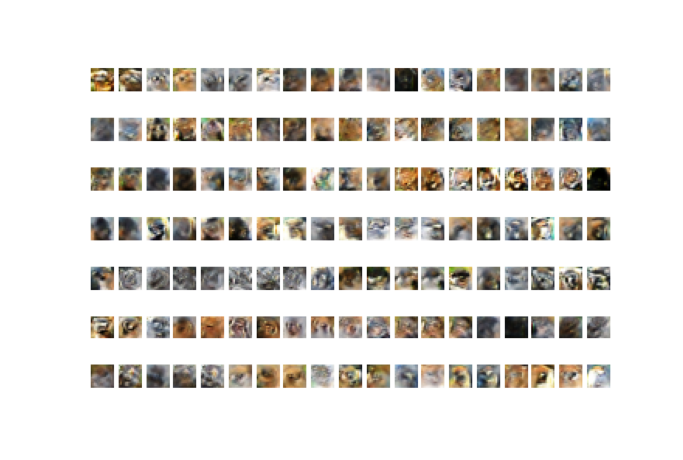

In [84]:
img = mpimg.imread(OUTPUT_CWGAN_DIR + 'generated_plot_e200.png')

plt.figure(figsize=(12,12))
plt.imshow(img)
plt.axis('off')
plt.show()

1/1 [==============================] - 1s 811ms/step


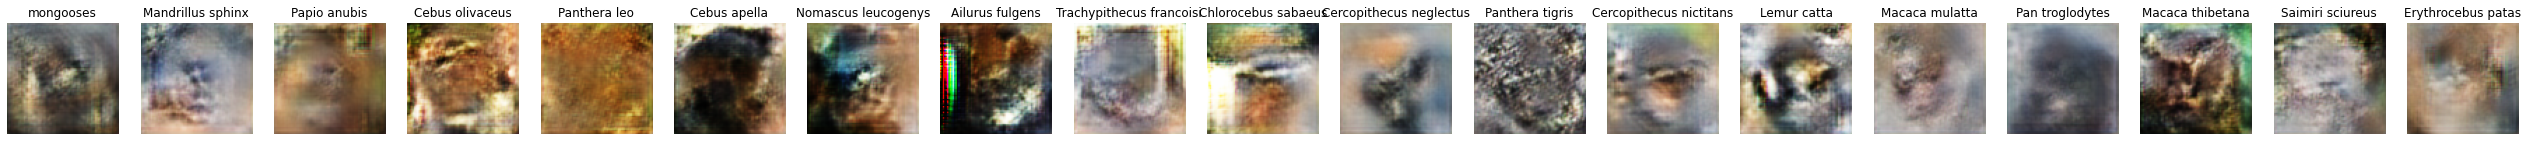

In [118]:
# generate some individual examples
img = generate_image(generator_cwgan, onehot_encoded=False)
plot_generated(img, num_classes)

## Exploring latent space and interpolation

1/1 [==============================] - 0s 349ms/step


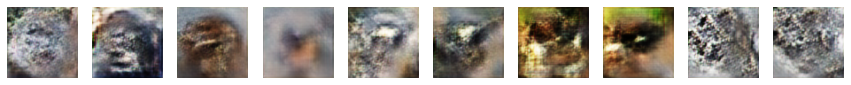

1/1 [==============================] - 0s 365ms/step


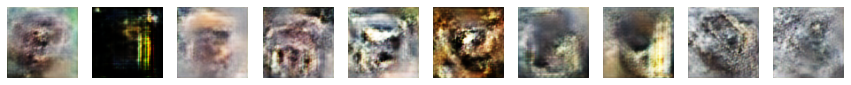

1/1 [==============================] - 1s 535ms/step


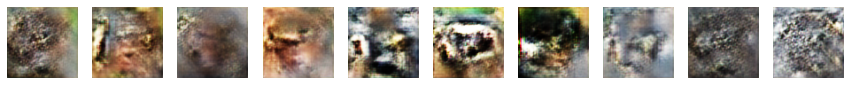

1/1 [==============================] - 0s 335ms/step


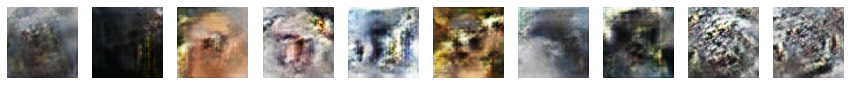

1/1 [==============================] - 0s 400ms/step


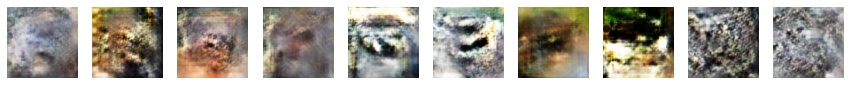

In [42]:
# choose the number of intermediate images that would be generated in
# between the interpolation + 2 (start and last images)
n_steps = 10  # @param {type:"integer"}

# how many examples to generate from this class
num_interpolation = 5 # @param {type:"integer"}

categoryA = "16) Macaca thibetana" #@param ['0) mongooses', '1) Mandrillus sphinx', '2) Papio anubis', '3) Cebus olivaceus', '4) Panthera leo','5) Cebus apella','6) Nomascus leucogenys','7) Ailurus fulgens','8) Trachypithecus francoisi','9) Chlorocebus sabaeus','10) Cercopithecus neglectus', '11) Panthera tigris', '12) Cercopithecus nictitans','13) Lemur catta','14) Macaca mulatta','15) Pan troglodytes','16) Macaca thibetana','17) Saimiri sciureus','18) Erythrocebus patas']
categoryB = "11) Panthera tigris" #@param ['0) mongooses', '1) Mandrillus sphinx', '2) Papio anubis', '3) Cebus olivaceus', '4) Panthera leo','5) Cebus apella','6) Nomascus leucogenys','7) Ailurus fulgens','8) Trachypithecus francoisi','9) Chlorocebus sabaeus','10) Cercopithecus neglectus', '11) Panthera tigris', '12) Cercopithecus nictitans','13) Lemur catta','14) Macaca mulatta','15) Pan troglodytes','16) Macaca thibetana','17) Saimiri sciureus','18) Erythrocebus patas']

yA = int(categoryA.split(')')[0])
yB = int(categoryB.split(')')[0])

display_interpolated(generator_cwgan, yA, yB, num_interpolation, n_steps, onehot_encoded=False)

# Notes

Conditional models allow to control from which class fake image will be generated. My idea was that we can control which classes we want to mix together by picking a class and interpolating the latent space. 

Conditional models should provide better quality images. Indeed, eyes are better preserved for CGAN with some other higher level features. They tend to be a bit less blurry, however significant amount of noise is still present. 

DCGAN was a bit stuck generating similar images (colors, mainly some monkeys), this problem is solved with Conditional models.

When interpolating between two classes, the images are also more diverse, which indicates that latent space is more complex. 

Introducing conditioning to WGAN-GP still produces noisy pictures, only now you can try to differentiate different blur shapes. However, still features of animals are not noticeable. CGAN still works better.